## Machine Learning Model

Traffic accident prediction is very difficult and requires non-accident data. It was therefore chosen to see if it was possible to predict whether an injury will occur in a traffic accident. Our hypothesis is that traffic injuries don't arise in a purely stochastic manner. It is believed their occurence is influenced by a multitude of factors such as drivers' physical conditions, car types, traffic condition and weather. 
In this section we will therefore investigate the possibility of predicting whether or not a traffic incident will involve an injury.


To do this two different machine learning models are used and tested on different feature sets. We are predicting on the "NUMBER OF INJURY" column and have transformed the column into a binary variable by combining all injuries over 0 to 1. Therefore it has been made into a binary classification problem. 


In [63]:
#Importing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import classification_report

In [64]:
df_persons = pd.read_csv('data/people_clean.csv')

In [65]:
df_persons = df_persons[~df_persons['PERSON_AGE'].isin(['Unspecified'])]
df_persons = df_persons[~df_persons['PERSON_SEX'].isin(['Unspecified'])]
df_persons["PERSON_AGE"] = pd.to_numeric(df_persons["PERSON_AGE"], downcast="float")
df_persons = df_persons.loc[(df_persons['PERSON_AGE']>np.float(0.0)) & (df_persons['PERSON_AGE'] < np.float(100.0) )]

df_sort = df_persons.groupby(['COLLISION_ID','PERSON_TYPE'],as_index=False).agg({'PERSON_AGE': ['min', 'max'],'PERSON_SEX': ['first','last']})

df_sort = df_sort[df_sort['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')
df_crash2 = df_crash[df_crash['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')

df_merged = pd.merge(df_crash2,df_sort, how='inner', left_index=True, right_index=True)
df_merged = df_merged.rename(columns = {df_merged.columns[-1] : 'PERSON_SEX2'})
df_merged = df_merged.rename(columns = {df_merged.columns[-2] : 'PERSON_SEX1'})
df_merged = df_merged.rename(columns = {df_merged.columns[-3] : 'PERSON_AGE2'})
df_merged = df_merged.rename(columns = {df_merged.columns[-4] : 'PERSON_AGE1'})
df_merged = df_merged.rename(columns = {df_merged.columns[-5] : 'PERSON_TYPE'})

#Creating a column of hour and day of the week.
df_merged['tod']=df_merged['CRASH TIME'].dt.hour
df_merged['dow']=df_merged['CRASH DATE'].dt.dayofweek

### Crash and People dataset

For this model the merged dataset consisting of the crash and people dataset have been used in order to combine different features of the datasets. Features such as time of day, day of the week, contributing factors for vehicle 1, lat and lng, person age, person type and vehicle type.

In [66]:
X = df_merged[['tod','dow','BOROUGH','CONTRIBUTING FACTOR VEHICLE 1','LATITUDE','LONGITUDE','PERSON_TYPE','PERSON_AGE1','VEHICLE TYPE CODE 1','NUMBER OF PERSONS INJURED']]
print('Shape before filtering {}'.format(X.shape))

X = X[X['CONTRIBUTING FACTOR VEHICLE 1'].isin(focusviolations)] #Focusviolation defined in beginning of notebook
X= X[X['VEHICLE TYPE CODE 1'].isin(focusvehicles)] #Focusvehicles defined in the beginning of notebook

X['NUMBER OF PERSONS INJURED'] = X['NUMBER OF PERSONS INJURED'].apply(lambda x: 0 if x == 'Unspecified' else x)#Changing unspecified to non-injury
X['NUMBER OF PERSONS INJURED'] = pd.to_numeric(X['NUMBER OF PERSONS INJURED'])
X['NUMBER OF PERSONS INJURED'] = X['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x > 0 else x) #Grouping all traffic incidents with injury to 1

X = X[~X.isin(['Unspecified'])] # Dropping all Unspecified in X
X = X.dropna()

#Ensuring both class have same number of incidents in order to avoid overfitting one class.
mi = min(X.groupby('NUMBER OF PERSONS INJURED').size())
ma = max(X.groupby('NUMBER OF PERSONS INJURED').size())
X = X.drop(X[X['NUMBER OF PERSONS INJURED']==0].sample(frac=(1-(mi/ma))).index)

print('Data after filtering',X.groupby(['NUMBER OF PERSONS INJURED']).size())

y = X['NUMBER OF PERSONS INJURED']
X = X.drop(columns=['NUMBER OF PERSONS INJURED'])

Shape before filtering (957796, 10)
Data after filtering NUMBER OF PERSONS INJURED
0.0    73463
1.0    74395
dtype: int64


Unfortunately in order to have similar amount of data in each class and filtering out unspecified values, a lot of data was dropped. 

In [67]:
#One hot encoding category columns. 
X = pd.get_dummies(X,columns=['BOROUGH','tod','dow','PERSON_TYPE','CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1'])
X['PERSON_AGE1'] = pd.to_numeric(X['PERSON_AGE1'])
header = X.columns.values.tolist()

X = X.values #to numpy
y = y.values # to numpy

#Splitting the dataset into train and test. 33% was used for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Standardizing non categorical columns
X_mean_train = X_train[:,:3].mean(axis=0)
X_std_train = X_train[:,:3].std(axis=0)
X_train[:,:3] = (X_train[:,:3] - X_mean_train) / X_std_train
X_mean_test = X_test[:,:3].mean(axis=0)
X_std_test = X_test[:,:3].std(axis=0)
X_test[:,:3] = (X_test[:,:3] - X_mean_test) / X_std_test

First logistic regression from scikit-learn is being tested. It is a simple ML-classification algorithm that is ised to predict the probability of a categorical binary dependent variable.

In [68]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)

prediction = clf.predict(X_test)

print('Accuracy of the logistic regression classifier on test set: {}'.format(accuracy_score(y_test,prediction)))

Accuracy of the logistic regression classifier on test set: 0.7198016149526582


The accuracy score predicts the labels for a sample which exactly match the corresponding set of labels in y_test. No further research is done for this model since it is simply used as a comparison for the random forrest model.

Next, Random Forest classifier from scikit-learn is being implemented. It is one of the best performing classifiers from scikit-learn and it is a set of decision trees from randomly selected subset of training set. It aggregates the 'votes' from the different decision trees to decide the final class of the test object.

In order to improve the model performance, hyperparameter tuning has been used to adjust the settings of the algorithm to optimize performance. However it is computationaly heavy, it is therefore a trade-off between performance vs. run time. Another drawback is it optimize on the training set, but will not be possible to generalize to new data. Therefore great care has to be taken in order to avoid overfitting. K-fold cross validation have been implemented in order to try to avoid overfitting. 

Simple RF-classifier is tested as a reference:

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
accuracy_score(y_test,prediction)

0.7129770053695127

In [70]:
#Parameter grid to sample from during fitting.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 1100, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [71]:
def evaluate(model,test_features,test_labels,title):
    # evaluating the best model with the parameters found in RandomizedSearchCV
    best_model = model.best_estimator_ # This selects the random forest with the best parameters
    global pred
    pred = best_model.predict(test_features)
    
    pred_probs = best_model.predict_proba(test_features)
    logloss_score = log_loss(test_labels, pred_probs)
    
    print('Accuracy score: {:0.4f}'.format(accuracy_score(test_labels,pred)))
    print('Log loss of the model given the test labels')
    print('Log loss error: {:0.4f}'.format(logloss_score))
    print(classification_report(test_labels,pred))
    plt.figure(figsize=(15,10))
    plt.suptitle(title, fontsize=16)
    conf_mat = confusion_matrix(test_labels, pred, normalize='true')      
    plt.figure(1)
    ax1= plt.subplot(1,2,1)
    sns.heatmap(conf_mat, annot=True, ax = ax1, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
    ax1.set_title('Confusion Matrix'); 
    ax1.xaxis.set_ticklabels(['Non-Injury', 'Injury']); ax1.yaxis.set_ticklabels(['Non-Injury','Injury']);
    
    ax2 = plt.subplot(1,2,2)
    # Compute ROC curve and ROC area for each class
    roc = metrics.plot_roc_curve(best_model, test_features, test_labels,ax=ax2)
    ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
    plt.tight_layout()
    plt.savefig('Confusion_ROC.png')
    plt.show()
    #Plotting the feature importance
    importance = best_model.feature_importances_
    from math import pi
    x_list = [str(x) for x in range(len(importance))]
    df_imp = pd.DataFrame({'x':x_list,'importance':importance,'header':header})
    source = ColumnDataSource(df_imp)
    source.data.keys()
    x_range = source.data['x'].tolist()
    p = figure(x_range=x_range,plot_width=700,plot_height=300,title='Feature Importance,ML-Model')
    p.vbar(x='x', top='importance',width=0.9,source=source)

    hover = HoverTool()
    hover.tooltips = [
    ("Feature:", "@header"),
    ('Importance:','@importance{0.000}')]

    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = 'Feature'
    p.yaxis.axis_label = 'Importance'
    p.xaxis.major_label_orientation = pi/2
    p.xaxis.major_label_text_font_size = '6pt'
    p.add_tools(hover)
#     output_file('ML_feature.html')
    show(p)
    

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   21.6s finished


Accuracy score: 0.7271
Log loss of the model given the test labels
Log loss error: 0.5074
              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75     24203
         1.0       0.79      0.63      0.70     24591

    accuracy                           0.73     48794
   macro avg       0.74      0.73      0.72     48794
weighted avg       0.74      0.73      0.72     48794



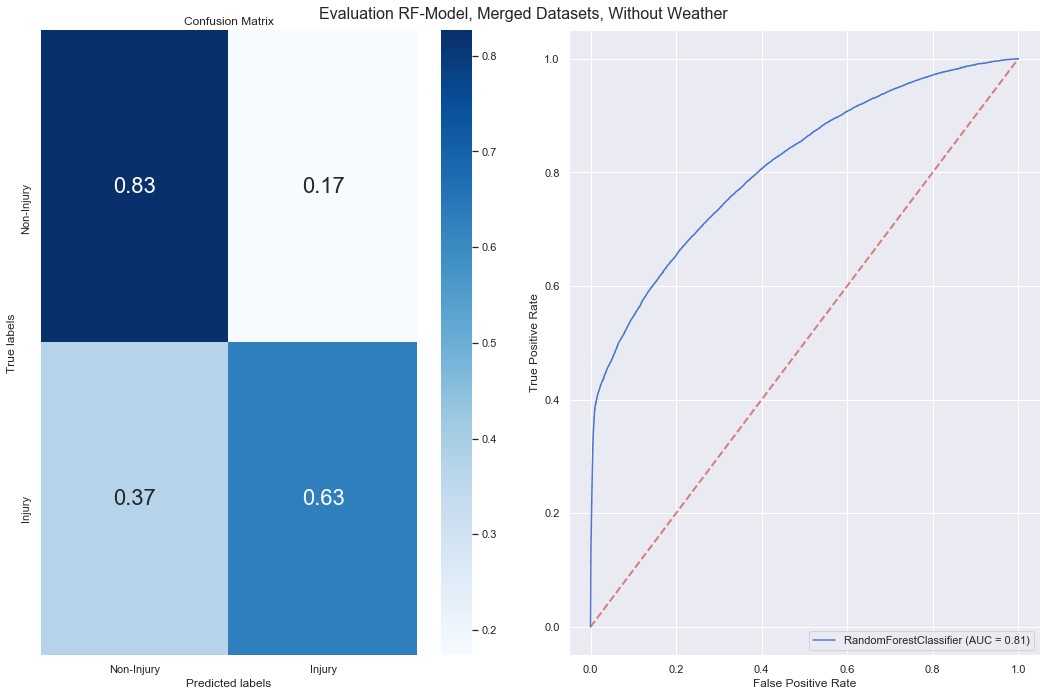

In [72]:
# Using the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, have reduced n iteration and cv for computation time. Tradeoff. Different values have been tested. set it low for quicker computation 
rf_random_tot = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_tot.fit(X_train, y_train)
#Evaluating model performance with the evaluate function
evaluate(rf_random_tot,X_test,y_test,'Evaluation RF-Model, Merged Datasets, Without Weather')

To evaluate the model performance, the two figures; the confusion matrix and the receiver operations characteristics curve (ROC) is analyzed. A confusion matrix is a table that is often used to describe the performance of a classification model. It allows for easy identification of confusion between the classes. In this case, it predict 87% of its non-injury predictions correctly and 69% of its injury predictions correctly. In addition to this, from the ROC curve, the model can correctly distinguish between the binary classes 72% of the time. Overall the model performs surprisingly well considering the classification problem.

From the feature importance it can see which features the model find most important. Features such as person type,person age, latitude, longitude play an important role.

## ML-Model with Weather

This machine learning model will be exploring whether weather increases the amount of information about the situation which can increase the accuracy of predicting injuries of the accident. To do this a weather dataset from 2012-2016 with weather attributes such as temperature, humidity, weather description and wind speed have been used. Originaly the weather description consisted of 62 unique categories. This have been reduced down to 8 categories in order to reduce feature vectors. The weather dataset was found [here](https://www.kaggle.com/selfishgene/historical-hourly-weather-data).

In [76]:
df_weather = pd.read_csv('data/Weather_Data.csv')
df_weather['datetime']=pd.to_datetime(df_weather['datetime'])
df_weather.head()

,Unnamed: 0,humidity,datetime,Temp,wind_direction,weather_description,wind_speed
0,1,58.0,2012-10-01 13:00:00,288.220000,260.0,cloudy,7.0
1,2,57.0,2012-10-01 14:00:00,288.247676,260.0,cloudy,7.0
2,3,57.0,2012-10-01 15:00:00,288.326940,260.0,cloudy,7.0
3,4,57.0,2012-10-01 16:00:00,288.406203,260.0,cloudy,7.0
4,5,57.0,2012-10-01 17:00:00,288.485467,261.0,cloudy,6.0


In [77]:
#Merging crash date and crash time
df_merged['datetime'] = pd.to_datetime(df_merged['CRASH DATE'].astype(str)+' '+df_merged['CRASH TIME'].astype(str))
df_m = df_merged
df_m['datetime'] = df_m['datetime'].dt.round(freq = 'H')
df_m = df_m.set_index('datetime')
df_weather = df_weather.set_index('datetime')
df_m.index = df_m.index.tz_convert(None)
#Merging the two datasets
df_m_w = pd.merge(df_m,df_weather, how='inner', left_index=True, right_index=True)

Extracting the model features similar to previous model

In [88]:
X = df_m_w[['tod','dow','BOROUGH','CONTRIBUTING FACTOR VEHICLE 1','LATITUDE','LONGITUDE','PERSON_TYPE','PERSON_AGE1','VEHICLE TYPE CODE 1','NUMBER OF PERSONS INJURED','humidity','Temp','wind_direction','weather_description','wind_speed']]
print('Shape of data before filtering data: {}'.format(X.shape))
X = X.reset_index()

X['NUMBER OF PERSONS INJURED'] = X['NUMBER OF PERSONS INJURED'].apply(lambda x: 0 if x == 'Unspecified' else x)
X['NUMBER OF PERSONS INJURED'] = pd.to_numeric(X['NUMBER OF PERSONS INJURED'])
X['NUMBER OF PERSONS INJURED'] = X['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x > 0 else x)

X = X.drop(columns=['datetime'])

#Filtering after focus sets made in the beginning of notebook.
X = X[X['CONTRIBUTING FACTOR VEHICLE 1'].isin(focusviolations)]
X= X[X['VEHICLE TYPE CODE 1'].isin(focusvehicles)]
X = X[~X.isin(['Unspecified'])]
X = X.dropna()

#Ensuring same number of incidents in each class to avoid overfitting.
mi = min(X.groupby('NUMBER OF PERSONS INJURED').size())
ma = max(X.groupby('NUMBER OF PERSONS INJURED').size())
X = X.drop(X[X['NUMBER OF PERSONS INJURED']==0].sample(frac=(1-(mi/ma))).index)

print('Size of data after filtering: {}'.format(X.groupby(['NUMBER OF PERSONS INJURED']).size()))
      
y = X['NUMBER OF PERSONS INJURED']

X = X.drop(columns=['NUMBER OF PERSONS INJURED'])
# X = X.drop(columns=['NUMBER OF PERSONS INJURED','CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1'])
X = pd.get_dummies(X,columns=['tod','dow','BOROUGH','weather_description','CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1','PERSON_TYPE'])
# X = pd.get_dummies(X,columns=['tod','dow','BOROUGH','weather_description','PERSON_TYPE'])
header = X.columns.values.tolist()

X = X.values #to numpy
y = y.values #to numpy
#train test split. 33% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Standardizing
X_mean_train = X_train[:,:7].mean(axis=0)
X_std_train = X_train[:,:7].std(axis=0)
X_train[:,:7] = (X_train[:,:7] - X_mean_train) / X_std_train

X_mean_test = X_test[:,:7].mean(axis=0)
X_std_test = X_test[:,:7].std(axis=0)
X_test[:,:7] = (X_test[:,:7] - X_mean_test) / X_std_test

Shape of data before filtering data: (446083, 15)
Size of data after filtering: NUMBER OF PERSONS INJURED
0.0    26600
1.0    26600
dtype: int64


Unfortunately the filtering have reduced the data points, but this filtering turned out to be the most optimal. First trying the model data on logistic regression.

In [79]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

prediction = clf.predict(X_test)

accuracy_score(y_test,prediction)

0.7713602187286398

In [80]:
#Simple random forrest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
accuracy_score(y_test,prediction)

0.774151287309182

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished


Accuracy score: 0.7799
Log loss of the model given the test labels
Log loss error: 0.4589
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80      8723
         1.0       0.85      0.69      0.76      8833

    accuracy                           0.78     17556
   macro avg       0.79      0.78      0.78     17556
weighted avg       0.79      0.78      0.78     17556



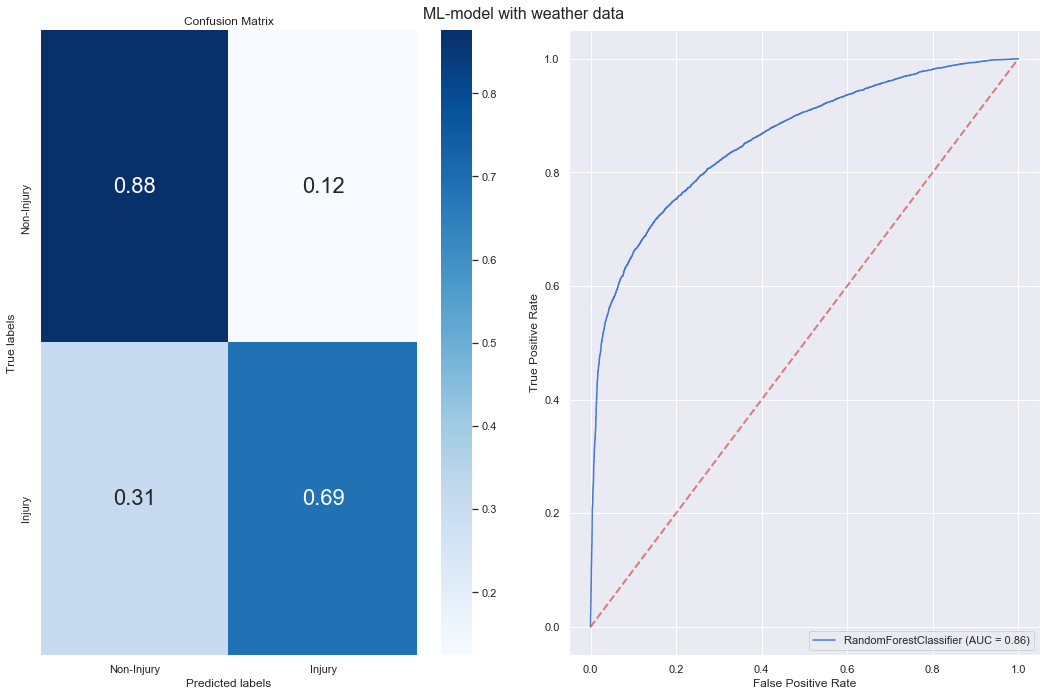

In [81]:
#Hyperparameter tuning
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, Different combinations of iterations and cv was checked. No big difference
rf_random_tot = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_tot.fit(X_train, y_train)

### Confusion Matrix

evaluate(rf_random_tot,X_test,y_test,'ML-model with weather data')

The results indicate that adding weather-related feaures to a machine learning algortihm in predicting traffic injuries did change the accuracy of the models. The weather attributes therefore have an influence on the models performance, which can also be seen on the feature importance.

The most dominating factor was the person type such as pedestrian, occupant and cyclist. With high probability it could be assumed the high feature importance of the bicyclist and pedestrian was due to the likelihood of an injury if either is involved. Since they have no form for protection besides a helmet they are likely to get injured in a traffic accident. 

A deeper look into the model is done. First the amount of predictions in each category

In [82]:
prediction = pred
print(np.unique(prediction, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0., 1.]), array([10419,  7137], dtype=int64))
(array([0., 1.]), array([8723, 8833], dtype=int64))


From this and the confusion matrix, the model have a tendency to predict non-injury which also reflect its high non-injury true positive. 
The accuracy of the model is investigated further for different districts in New York with a choropleth map.

In [83]:
import shapefile
from shapely.geometry import shape, Point
#Function to read in shapefile
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def calc_color(data, color=None):
        if color   == 1: 
            color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; 
            colors = 'Purples';
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; 
            colors = 'YlGnBu';
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        new_data, bins = pd.qcut((data + np.random.normal(0,0.001,len(data))), 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

def plot_comunas_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        i = i
        comuna_id.append(df[df.boro_cd == 
                            i].index.to_numpy()[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id,df.boro_cd.to_numpy(), 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9));

def plot_map_fill_multiples_ids_tone(sf, title, comuna,comunas,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''       
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    ax.grid(False)
    fig.suptitle(title, fontsize=16)
    
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        for id in range(len(comuna)):
            shape_ex = sf.shape(id)
            x_lon = np.zeros((len(shape_ex.points),1))
            y_lat = np.zeros((len(shape_ex.points),1))
            for ip in range(len(shape_ex.points)):
                x_lon[ip] = shape_ex.points[ip][0]
                y_lat[ip] = shape_ex.points[ip][1]
            ax.fill(x_lon,y_lat, color_ton[id])
            if print_id != False:
                x0 = np.mean(x_lon)
                y0 = np.mean(y_lat)
                plt.text(x0, y0, comunas[id], fontsize=10,backgroundcolor = 'w')
        if (x_lim != None) & (y_lim != None):     
            plt.xlim(x_lim)
            plt.ylim(y_lim)
        

Shapefile used for the New York district was found [here](https://data.cityofnewyork.us/City-Government/Community-Districts/yfnk-k7r4)

This function takes lat lon as input and then check if the coordinates is in that shape. 


1: 0 => 44 
2: 45 => 56 
3: 57 => 60 
4: 61 => 67 
5: 68 => 74 
6: 75 => 99 

   1   2   3   4   5   6


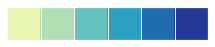

<Figure size 792x648 with 0 Axes>

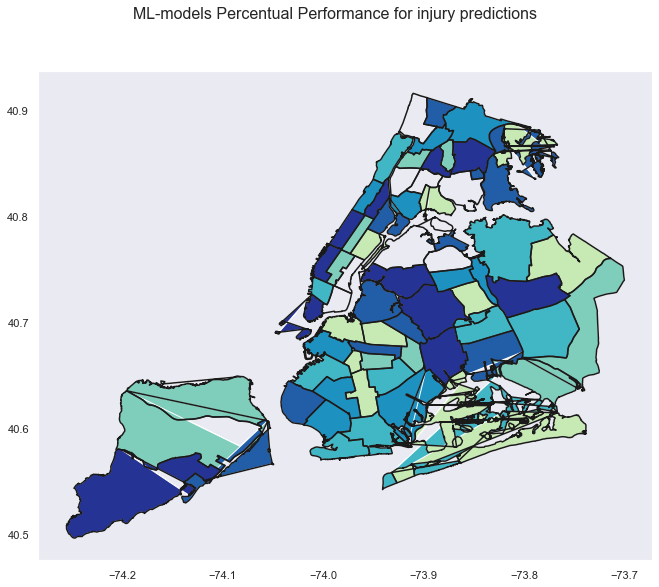

In [89]:
#Reading in shapefile
import shapefile as shp
sf = shp.Reader('data/geo.shp')

X_test_n = X_test
X_test_n[:,:7] = X_test_n[:,:7]*X_std_test+X_mean_test #Transforming X test back to original values
X_test_n = np.vstack(((X_test_n.T),prediction,y_test,)).T #stacking with prediction and y_test
#Make dataframe
df_Xtest = pd.DataFrame({'LATITUDE': X_test_n[:, 0], 'LONGITUDE': X_test_n[:, 1],'PERSON_AGE1':X_test_n[:,2],'humidity': X_test_n[:,3],'Temp':X_test_n[:,4],'prediction':X_test_n[:,-2],'y_test':X_test_n[:,-1]})
df_c = df_Xtest.values[:1000] #snipping for computation time. Plot in webpage has more datapoints.

lis = []
ind = []

# get the shapes
shapes = sf.shapes()
all_records = sf.records()

def check(lon, lat):
    # build a shapely point from your geopoint
    point = Point(lon, lat)

    # the contains function does exactly what you want
    return polygon.contains(point)

for j in range(df_c.shape[0]):
    for i in range(len(shapes)):
#         print('yes')
        polygon=shape(shapes[i])
        
        all_records[1][0]
        test = check(df_c[j,1],df_c[j,0])
        if test == True:
            lis.append(all_records[i][0])
            ind.append(j)
            continue
lis = np.array(lis)

XX = df_Xtest.loc[df_Xtest.index.isin(ind)] #Removing variables in none of the shapes
XX['area'] =lis
cor_pred = XX[XX['prediction'] == XX['y_test']]

percentage = (cor_pred.groupby('area').size())/(XX.groupby('area').size())
percentage = percentage.fillna(0)

south = percentage.index.to_list()
data = (percentage*100).to_list()

print_id = True # The shape id will be printed
color_palette = 2 # 'Purples'
plot_comunas_data(sf, 'ML-models Percentual Performance for injury predictions', south, data, color_palette, False)

The choropleth map shows the accuracy of the model in the different districts in New York. It is possible to see in some regions the model performs well but less in others. Maybe this coincide with the districts that have very dangerous roads and thus the model has an easier time identifying injuries.

Investigating further into the weather feature importance to see if it possible to detect why they play an importance

In [90]:
df_T = df_Xtest.where(cond=(df_Xtest['prediction']==df_Xtest['y_test'])).dropna() #Correct predictions
df_TF = df_Xtest.where(cond=(df_Xtest['prediction']!=df_Xtest['y_test'])).dropna() #Incorrect predictions. 

from bokeh.transform import factor_cmap, linear_cmap,jitter
source = ColumnDataSource(df_T)
source2 = ColumnDataSource(df_TF)
#Bokeh plot temperature feature
p_T = figure(plot_width=700, plot_height=300, title="Temperature Injury Predictions",toolbar_location="left")
c1 = p_T.circle(x='Temp', y=jitter('prediction', width=0.7),source=source, alpha=0.1,color='green')
c2 = p_T.circle(x='Temp', y=jitter('prediction', width=0.7),source=source2, alpha=0.1,color='red')
p_T.ygrid.grid_line_color = None
p_T.xaxis.axis_label = "Temp"
p_T.legend.location = "center"
p_T.legend.orientation = "horizontal"
legend = Legend(items=[
    ("Predicted Correctly"   , [c1]),
    ("Predicted Wrong" , [c2])
], location="center")
p_T.add_layout(legend, 'right')
p_T.legend.click_policy="hide"
p_T.yaxis.major_label_overrides = {0: 'Non-Injury', 0.5:'', 1: 'Injury'}
p_T.yaxis.major_label_orientation = "vertical"

#Bokeh plot humidity feature
p_H = figure(plot_width=700, plot_height=300, title="Humidity Injury Predictions",toolbar_location="left")
c1 = p_H.circle(x='humidity', y=jitter('prediction', width=0.7),source=source, alpha=0.1,color='green')
c2 = p_H.circle(x='humidity', y=jitter('prediction', width=0.7),source=source2, alpha=0.1,color='red')
p_H.ygrid.grid_line_color = None
p_H.xaxis.axis_label = "Humidity"
p_H.legend.location = "center"
p_H.legend.orientation = "horizontal"
legend = Legend(items=[
    ("Predicted Correctly"   , [c1]),
    ("Predicted Wrong" , [c2])
], location="center")
p_H.add_layout(legend, 'right')
p_H.legend.click_policy="hide"
p_H.yaxis.major_label_overrides = {0: 'Non-Injury', 0.5:'', 1: 'Injury'}
p_H.yaxis.major_label_orientation = "vertical"
show(column(p_T,p_H))

From the temperature feature it is observed that at lower temperature there is a higher likelihood for injuries which the model seems to pick up on which could play an role in its feature importance.
In the humidity prediction it is more difficult to find a pattern in the models prediction. It seems stochastic. 

Overall the model performed quite well considering traffic injuries could be assumed to be a stochastic event. 

## 4 Genre

The main visualization genre used in the project is the magazine style with some elements of partitioned poster, annotated chart and film/video/animation. Many of the vizualisations are combinations of the magasize style and annotated charts in the sense that most visualizations are both accompanied with text and interactive features. This is useful for communicating certain information about the data, while at the same time allowing the user to interact with the visualization to investigate additional information in the plot. By for example exploring the annotations in the form of hover tools and selecting different tabs.
The visualizations containing bokeh plots in tabs can be seen as a partitioned poster with accompanying text above and below. 
Each tab is used to communicate different sides of the 'same' analysis. 


The tools used from figure 7 in Segal and Heer are mentioned and discussed below.

**Visual structuring**

* Establishing shot

As a starting point to the website, a plot of the gps coordinates for all the crashes is show. This provides a great overview of what the website is about and might even peak the readers interest. 

* Progress bar

There is no concrete progess bar on the webite, but the structure of the page itself can be seen as a progress bar. As the user scrolls through the website the scroll bar on the right indicates how long the webpage is.  

**Highlighting**

* Feature distinction

Colors are used to highlight the data points in the plots containing maps and to distinguish crashes in different boroughs and on different roads. This is done to convey the correct information by clearly separating the relevant information. 

* Zooming

The bokeh plots of maps have a zoom feature that allows the user to investigate intersting areas of the map by zooming. This is a usefull feature for visualizations containing maps as it would be a common wish for a reader looking at a map to explore different sections of the map and to highlight these sections by zooming/panning.  


**Transition guidance**

* Familiar objects. 

Tabs are used to help the user transition between bokeh plots. It is a simple and obvious way of allowing the user to transition between visualizations. 



**Ordering**

* User Directed Path

Tabs are availeble for the user to click as well as interactive tool which allows the users to investigate what they want. 


* Linear

The bar plot of dangerous roads is an example of a linear ordering. There is one plot and the reader can read it from the top down. 


* Random access

The partitioned poster genre used is a form of random acces where there is no particular order of the images. For example in the machine learning visualizations. 


**Interactivity**

* Hover highlighting

Hover tools are applied in the bokeh plots. This is a neat feature that could give the reader additional information about the data compared to only the data shown. On some cases, the hover tool might even be necessary to give the reader all that is needed to understand the visualization. Which is the case in the dangerous roads map as the hover tool here lets the user know what road each line section corresponds to.  

* Limited interactivity

Some visualizations do not allow the user to interact with them. For example the machine learning results. This is to clearly convey the result of the model and show what we deemed most important. It is a case where the user should simply "obseve" the results presented and not interact with it.  

* Explicit instruction

The dangerous roads map is accompanied by text that tells the user what to investigate. This is to ensure that the user is aware of how they should use the plot. This is important as the vizualisation contains many datapoints which makes it slow so the user needs to know what to look for.   

* Stimulating default views
The interactive bokeh maps are stimulating in themselves as maps by default are interesting to look at and accompanied by the datapoints it promotes user exploration by using the bokeh zoom and panning tools. 


**Messaging**

* Captions/ Headlines

Most figures have headlines as it provides the user with an overall context of the plot. By reading the headline it is clear to the reader what to expect from the visualization. 


* Annotations

This is applied in the seaborn heatmap of crash distribution over time to give the reader explicit numbers for easier comparison of different sections in the heatmap instead of just color based approximate values. 

* Multi-messaging
The combination of hover tools and map/bar plots provide the user with different and relevant information about the same data.  

* Introductory text

Introductory texts are used for all visualizations to better guide the reader through the narrative we are trying to convey. 

* Summary

A summary is applied after each individual visualisation explaining the key takeaways from those visualizations. This was done to always guide the reader, and again, make sure that the key points always reach the reader. 


## 5 Visualizations

A lot of different visualization methods have been implemented. The high variety in plots and plot-types engages the reader more by being more captivating. This is also the reason why there is often a switch between interactive and non-interactive figures. Too many interactive plots and the message can get lost, to few makes it boring and monotonous.

Traffic incidents is also a very visual topic as the crash itself contains a GPS location, hence the amount of maps used in the notebook and website. Again it was tried to vary the map types to keep it intriguing but without confusing the reader. 
Different map types created:
* Hvplot-dataloader map - map of all traffic incidents. Dataloader was used to decrease computation time.
* Folium heat map, animation - traffic incidents pr hour of the day, gif.
* Folium marker cluster - detailed interactive visualization of incidents. 
* Chloropleth map - Injury distribution of boroughs + ML percentual performance.
* Bokeh map plot - Dangerous intersections with interactive legend.

From these, we chose to show the Folium marker cluster map, the chloropleth map and the Bokeh map plots, as they were, in our opinion, the best way of getting the important information across in a light and digestable manner. We included a small "treasure hunt" in the Folium map, to combine some interesting information about a specific crash with the interactive plots, to guide the reader towards something usable.

In regards to the interactive bar plots, we had too much information in the data to simple plot them all side by side in a regular bar plot - this would fill up the entire website with plots, and the reader would get lost in translation. Instead, we opted to go the interactive route, which still poses the risk of the reader missing the key information we wanted to show. To combat this in the website, we have written the observations we wanted to show in a list below the plot.


Sometimes, however, we still need good old bar charts, so we included them for the variables for which it made sense, i.e. number of persons, cyclists or motorcyclists injured. Another static plot was the heatmap, which made the general monthly trend of number of crashes visible in a nice colorful way.




## 6 Discussion

### Success in our data analysis and visualizations
This project was by large a success, in which the three of us (Magnus, Anders T and Anders D) completed the task we set out to do. We wanted to visualize some interesting stuff from the NYC Motor Vehicle Collisions data sets, and use them for something tangible. To that end, we chose to restructure the 'NUMBER OF PERSONS INJURED' feature into a binary classification problem. To get satisfactory results, we tried a variety of classifiers, including Logistic Regression as a baseline, and i.e. the Support Vector Machine in addition to the actual chosen predictor, the Random Forest. 

This part was completed, but there is always something to improve when handling machine learning models. A common phrase is "all models are wrong, but some are usefull" comes to mind when evaluating the usefulness of our project. Below we list some of the things we wanted to improve upon if we were to come back to this project in the future.


### Improvements to be done

* Proper feature handling of age and genders (how do we look at the crashes, solo accidents vs 2 cars in a single crash etc.) 
* Incorporation of more data (Lots of columns unused)
* API enrichment
* More detailed usage of weather data

One of the main things here is selecting the relevant features from the data sets, without removing too much data. The machine learning models are very sensitive to the amount of data we train on, so clever feature transformations to maximize the amount of data points, or usage of bootstrapping method etc. would be a no-brainer. 

Another way to solve this is to use APIs to enrich the data set, such that the predictive capability increases, much like what we saw with the inclusion of weather data. This is another bottomless pit, as one could imagine a ton of avenues here (more data about the drivers, criminal records, data about construction sites blocking roads etc.). But as we had a time restriction, we opted to focus our attention on the data we had in addition to the weather data.

## 7 Contributions

**s153327 Magnus**
* Setup of Github repository and website on Github Pages. 
* Dangerous roads analysis. Bokeh bar plot and Bokeh map plot. Clorpleth map.
* Prior dataset cleaning.
* Basic stats and exploration. 
* Genre 
* Webpage text

**s153242 Anders T**
* Basic stats
* Exploration of Data, map plots
* Machine Learning Model
* Visualization
* Webpage text

**s144108 Anders D**
* Data analysis (age/gender and bokeh bar plots temporal)
* Machine Learning Model
* Visualization and Discussion
* Webpage text
* Vehicle types/ Contributing factor analysis.  

